<a href="https://colab.research.google.com/github/bachsykhang/StockPredictVinamilk/blob/main/Vinamilk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bước 1: Import thư viện

In [1]:
import pandas as pd #đọc dữ liệu
import numpy as np #xử lý dữ liệu
import matplotlib.pyplot as plt #vẽ biểu đồ
from sklearn.preprocessing import MinMaxScaler #chuẩn hóa dữ liệu
from keras.callbacks import ModelCheckpoint #lưu lại huấn luyện tốt nhất
from tensorflow.keras.models import load_model #tải mô hình

#các lớp để xây dựng mô hình
from keras.models import Sequential #đầu vào
from keras.layers import LSTM #học phụ thuộc
from keras.layers import Dropout #tránh học tủ
from keras.layers import Dense #đầu ra

#kiểm tra độ chính xác của mô hình
from sklearn.metrics import r2_score #đo mức độ phù hợp
from sklearn.metrics import mean_absolute_error #đo sai số tuyệt đối trung bình
from sklearn.metrics import mean_absolute_percentage_error #đo % sai số tuyệt đối trung bình

# Bước 2: Đọc dữ liệu

In [2]:
# đọc dữ liệu từ file csv
df = pd.read_csv('BTC_USD.csv')

# Bước 3: Mô tả dữ liệu

In [3]:
#định dạng cấu trúc thời gian
df["Ngày"] = pd.to_datetime(df.Ngày,format="%d/%m/%Y")

In [4]:
#kích thước dữ liệu
df.shape

(2557, 7)

In [5]:
#dữ liệu 5 dòng đầu
df.head()

,Ngày,Đóng cửa,Mở cửa,Cao nhất,Thấp nhất,KL,% Thay đổi
0,2024-12-10,"95,270.00","97,500.00","98,357.00","94,513.00",1.32K,-2.29%
1,2024-12-09,"97,500.00","101,240.00","101,280.00","94,255.00",1.58K,-3.69%
2,2024-12-08,"101,240.00","99,936.00","101,480.00","98,803.00",0.42K,1.30%
3,2024-12-07,"99,936.00","99,786.00","100,530.00","99,016.00",0.36K,0.15%
4,2024-12-06,"99,786.00","96,833.00","101,900.00","96,283.00",1.46K,3.05%


In [6]:
#xác định kiểu dữ liệu
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2557 entries, 0 to 2556
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Ngày        2557 non-null   datetime64[ns]
 1   Đóng cửa    2557 non-null   object        
 2   Mở cửa      2557 non-null   object        
 3   Cao nhất    2557 non-null   object        
 4   Thấp nhất   2557 non-null   object        
 5   KL          2557 non-null   object        
 6   % Thay đổi  2557 non-null   object        
dtypes: datetime64[ns](1), object(6)
memory usage: 140.0+ KB


In [7]:
#mô tả bộ dữ liệu
df.describe()

,Ngày
count,2557
mean,2021-06-11 00:00:00
min,2017-12-11 00:00:00
25%,2019-09-11 00:00:00
50%,2021-06-11 00:00:00
75%,2023-03-12 00:00:00
max,2024-12-10 00:00:00


# Bước 4: Tiền xử lý dữ liệu

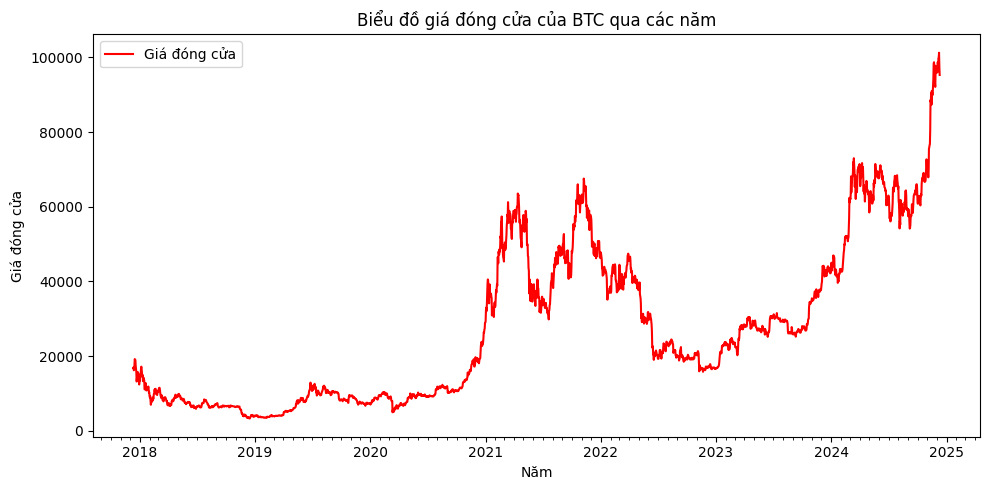

In [8]:
from matplotlib.dates import YearLocator, DateFormatter, MonthLocator # Thêm MonthLocator vào để sửa lỗi

# Chuyển đổi cột "Ngày" sang dạng datetime
df['Ngày'] = pd.to_datetime(df['Ngày'], format='%d/%m/%Y')

# Sắp xếp lại dữ liệu theo thứ tự thời gian
df = df.sort_values(by='Ngày')

# Chuyển đổi định dạng các cột giá thành số thực
df['Đóng cửa'] = df['Đóng cửa'].str.replace(',', '').astype(float)
df['Mở cửa'] = df['Mở cửa'].str.replace(',', '').astype(float)
df['Cao nhất'] = df['Cao nhất'].str.replace(',', '').astype(float)
df['Thấp nhất'] = df['Thấp nhất'].str.replace(',', '').astype(float)

# Lấy thông tin năm từ cột "Ngày"
df['Năm'] = df['Ngày'].dt.year

# Tạo đồ thị giá đóng cửa qua các năm
plt.figure(figsize=(10, 5))
plt.plot(df['Ngày'], df['Đóng cửa'], label='Giá đóng cửa', color='red')
plt.xlabel('Năm')
plt.ylabel('Giá đóng cửa')
plt.title('Biểu đồ giá đóng cửa của BTC qua các năm')
plt.legend(loc='best')

# Định dạng đồ thị hiển thị các ngày tháng theo năm-tháng
years = YearLocator()
yearsFmt = DateFormatter('%Y')
months = MonthLocator()  # Thêm dòng này để khai báo MonthLocator
plt.gca().xaxis.set_major_locator(years)
plt.gca().xaxis.set_major_formatter(yearsFmt)
plt.gca().xaxis.set_minor_locator(months)

plt.tight_layout()
plt.show()

In [9]:
df1 = pd.DataFrame(df,columns=['Ngày','Đóng cửa'])
df1.index = df1.Ngày
df1.drop('Ngày',axis=1,inplace=True)
df1

,Đóng cửa
Ngày,
2017-12-11,16754.0
2017-12-12,16967.0
2017-12-13,16181.0
2017-12-14,16383.0
2017-12-15,17522.0
...,...
2024-12-06,99786.0
2024-12-07,99936.0
2024-12-08,101240.0


In [10]:
#chia tập dữ liệu
data = df1.values
train_data = data[:1500]
test_data = data[1500:]

In [11]:
data

array([[ 16754.],
       [ 16967.],
       [ 16181.],
       ...,
       [101240.],
       [ 97500.],
       [ 95270.]])

In [12]:
#chuẩn hóa dữ liệu
sc = MinMaxScaler(feature_range=(0,1))
sc_train = sc.fit_transform(data)

In [13]:
#tạo vòng lặp các giá trị
x_train,y_train=[],[]
for i in range(50,len(train_data)):
  x_train.append(sc_train[i-50:i,0]) #lấy 50 giá đóng cửa liên tục
  y_train.append(sc_train[i,0]) #lấy ra giá đóng cửa ngày hôm sau

In [14]:
x_train

[array([0.13752128, 0.1396957 , 0.13167179, 0.13373392, 0.14536144,
        0.16235866, 0.16015362, 0.1597759 , 0.14355453, 0.13416268,
        0.12642256, 0.10093388, 0.10976426, 0.10405769, 0.10555835,
        0.1265471 , 0.1234335 , 0.11262266, 0.11264307, 0.0928385 ,
        0.10736526, 0.10281225, 0.11665299, 0.12119783, 0.12124887,
        0.13918528, 0.14167616, 0.13182492, 0.11890091, 0.11372518,
        0.11855382, 0.1019139 , 0.10719171, 0.1113568 , 0.10489479,
        0.10506834, 0.07951636, 0.07961845, 0.07924073, 0.08364061,
        0.0964217 , 0.08402853, 0.07644359, 0.0769336 , 0.08300768,
        0.08027179, 0.07949594, 0.08348748, 0.08734631, 0.08094556]),
 array([0.1396957 , 0.13167179, 0.13373392, 0.14536144, 0.16235866,
        0.16015362, 0.1597759 , 0.14355453, 0.13416268, 0.12642256,
        0.10093388, 0.10976426, 0.10405769, 0.10555835, 0.1265471 ,
        0.1234335 , 0.11262266, 0.11264307, 0.0928385 , 0.10736526,
        0.10281225, 0.11665299, 0.12119783, 0.

In [15]:
y_train

[0.07035929977582045,
 0.07147203064195384,
 0.06021303181389424,
 0.05730053533584054,
 0.060604018898049346,
 0.050197433164688256,
 0.037435737240345775,
 0.04482569938707926,
 0.043939598110195065,
 0.05055575292066331,
 0.05513019971987767,
 0.0539041540591197,
 0.04886011441731695,
 0.05734953632811065,
 0.053422310968463775,
 0.06301323435132894,
 0.06854115879179887,
 0.07022658875508897,
 0.0793275022152532,
 0.07237038216690556,
 0.0805474227519774,
 0.08100680705450952,
 0.0732176909915759,
 0.06683735345640748,
 0.07005304357413239,
 0.06516621544919618,
 0.06405450543706842,
 0.07184974662403582,
 0.07438146455799063,
 0.07178849538369819,
 0.07801570481802256,
 0.07903655882364952,
 0.08327310294700135,
 0.08389582389043379,
 0.08302809798565089,
 0.07592295410648733,
 0.06758155602650953,
 0.06142682722658468,
 0.0605795184019143,
 0.05593463267631169,
 0.06375437435941411,
 0.05959949855651244,
 0.05974241811730021,
 0.05006063872793424,
 0.0507374649336649,
 0.05071806

In [16]:
#xếp dữ liệu thành 1 mảng 2 chiều
x_train = np.array(x_train)
y_train = np.array(y_train)

#xếp lại dữ liệu thành mảng 1 chiều
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
y_train = np.reshape(y_train,(y_train.shape[0],1))

# Bước 5: Xây dựng và huấn luyện mô hình

In [17]:
#xây dựng mô hình
model = Sequential() #tạo lớp mạng cho dữ liệu đầu vào
#2 lớp LSTM
model.add(LSTM(units=128,input_shape=(x_train.shape[1],1),return_sequences=True))
model.add(LSTM(units=64))
model.add(Dropout(0.5)) #loại bỏ 1 số đơn vị tránh học tủ (overfitting)
model.add(Dense(1)) #output đầu ra 1 chiều
#đo sai số tuyệt đối trung bình có sử dụng trình tối ưu hóa adam
model.compile(loss='mean_absolute_error',optimizer='adam')
model.summary()

c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 116,033 (453.25 KB)

 Trainable params: 116,033 (453.25 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
#huấn luyện mô hình
save_model = "save_model.keras"
best_model = ModelCheckpoint(save_model,monitor='loss',verbose=2,save_best_only=True,mode='auto')
model.fit(x_train,y_train,epochs=100,batch_size=50,verbose=2,callbacks=[best_model])

Epoch 1/100

Epoch 1: loss improved from inf to 0.04919, saving model to save_model.keras
29/29 - 3s - 94ms/step - loss: 0.0492
Epoch 2/100

Epoch 2: loss improved from 0.04919 to 0.02346, saving model to save_model.keras
29/29 - 1s - 25ms/step - loss: 0.0235
Epoch 3/100

Epoch 3: loss improved from 0.02346 to 0.02290, saving model to save_model.keras
29/29 - 1s - 25ms/step - loss: 0.0229
Epoch 4/100

Epoch 4: loss improved from 0.02290 to 0.02133, saving model to save_model.keras
29/29 - 1s - 25ms/step - loss: 0.0213
Epoch 5/100

Epoch 5: loss did not improve from 0.02133
29/29 - 1s - 24ms/step - loss: 0.0217
Epoch 6/100

Epoch 6: loss improved from 0.02133 to 0.02109, saving model to save_model.keras
29/29 - 1s - 25ms/step - loss: 0.0211
Epoch 7/100

Epoch 7: loss did not improve from 0.02109
29/29 - 1s - 25ms/step - loss: 0.0212
Epoch 8/100

Epoch 8: loss improved from 0.02109 to 0.02068, saving model to save_model.keras
29/29 - 1s - 25ms/step - loss: 0.0207
Epoch 9/100

Epoch 9: lo

In [19]:
#dữ liệu train
y_train = sc.inverse_transform(y_train) #giá thực
final_model = load_model("save_model.keras")
y_train_predict = final_model.predict(x_train) #dự đoán giá đóng cửa trên tập đã train
y_train_predict = sc.inverse_transform(y_train_predict) #giá dự đoán

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


# Bước 6: Tái sử dụng mô hình

In [20]:
#xử lý dữ liệu test
test = df1[len(train_data)-50:].values
test = test.reshape(-1,1)
sc_test = sc.transform(test)

x_test = []
for i in range(50,test.shape[0]):
  x_test.append(sc_test[i-50:i,0])
x_test = np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

#dữ liệu test
y_test = data[1500:] #giá thực
y_test_predict = final_model.predict(x_test)
y_test_predict = sc.inverse_transform(y_test_predict) #giá dự đoán

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


# Độ chính xác của mô hình

C:\Users\Admin\AppData\Local\Temp\ipykernel_17524\1519449110.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data1['Dự đoán'] = y_train_predict #thêm dữ liệu
C:\Users\Admin\AppData\Local\Temp\ipykernel_17524\1519449110.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data1['Dự đoán'] = y_test_predict #thêm dữ liệu


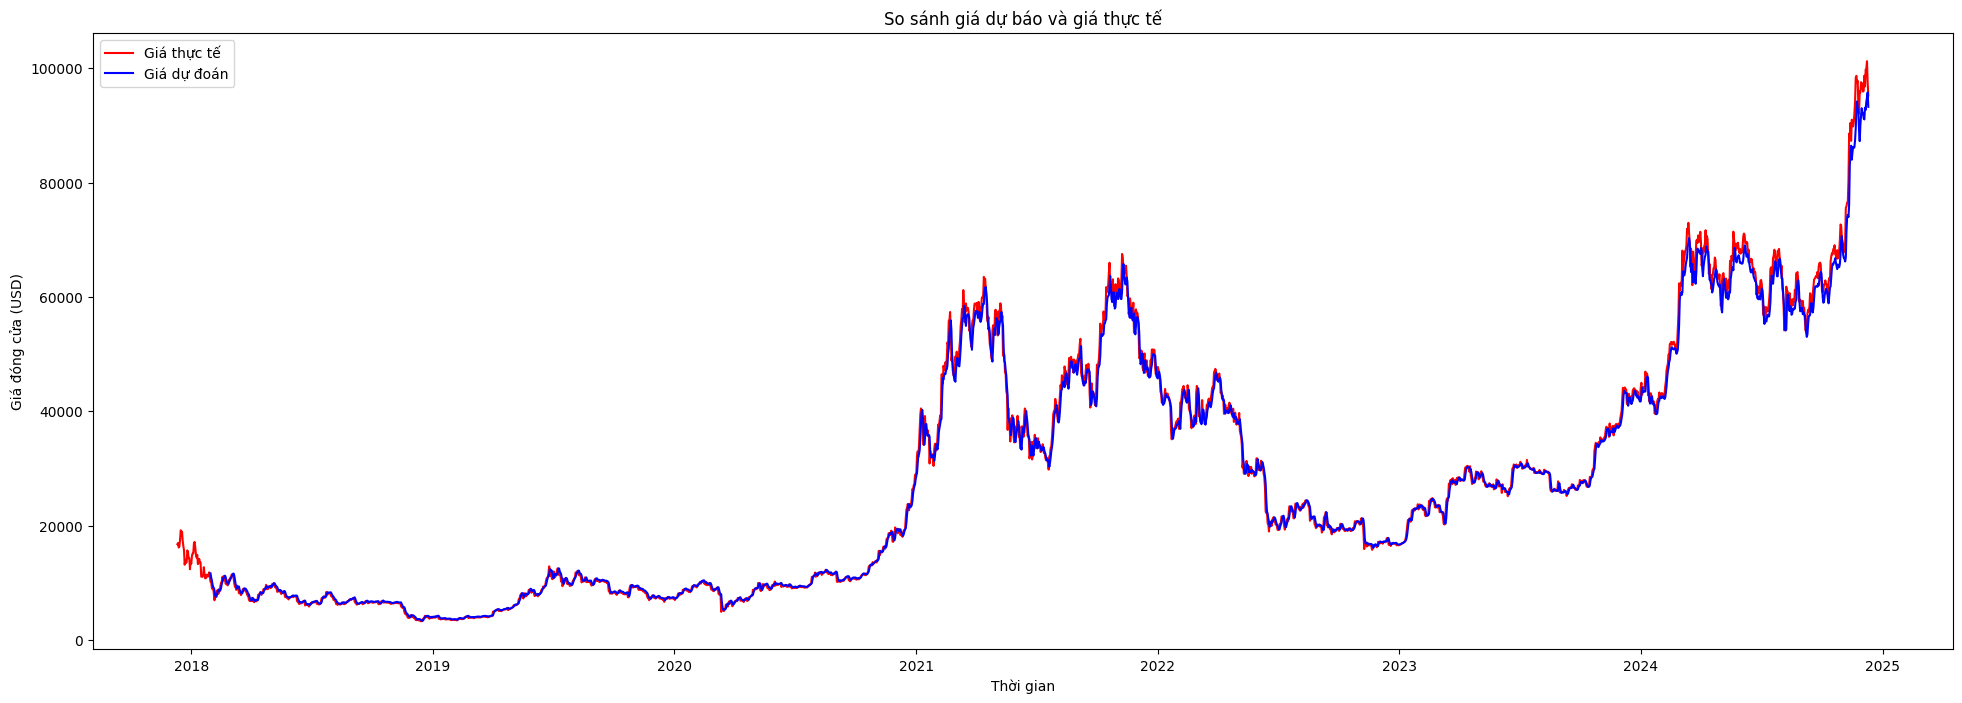

In [21]:
#lập biểu đồ so sánh
train_data1 = df1[50:1500]
test_data1 = df1[1500:]

plt.figure(figsize=(24,8))
plt.plot(df1,label='Giá thực tế',color='red') #đường giá thực
train_data1['Dự đoán'] = y_train_predict #thêm dữ liệu
plt.plot(train_data1['Dự đoán'],color='blue') #đường giá dự báo train
#label='Giá dự đoán train'
test_data1['Dự đoán'] = y_test_predict #thêm dữ liệu
plt.plot(test_data1['Dự đoán'],label='Giá dự đoán',color='blue') #đường giá dự báo test
plt.title('So sánh giá dự báo và giá thực tế') #đặt tên biểu đồ
plt.xlabel('Thời gian') #đặt tên hàm x
plt.ylabel('Giá đóng cửa (USD)') #đặt tên hàm y
plt.legend() #chú thích
plt.show()

C:\Users\Admin\AppData\Local\Temp\ipykernel_17524\708662945.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data1['Dự đoán'] = y_train_predict #thêm dữ liệu
C:\Users\Admin\AppData\Local\Temp\ipykernel_17524\708662945.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data1['Dự đoán'] = y_test_predict #thêm dữ liệu


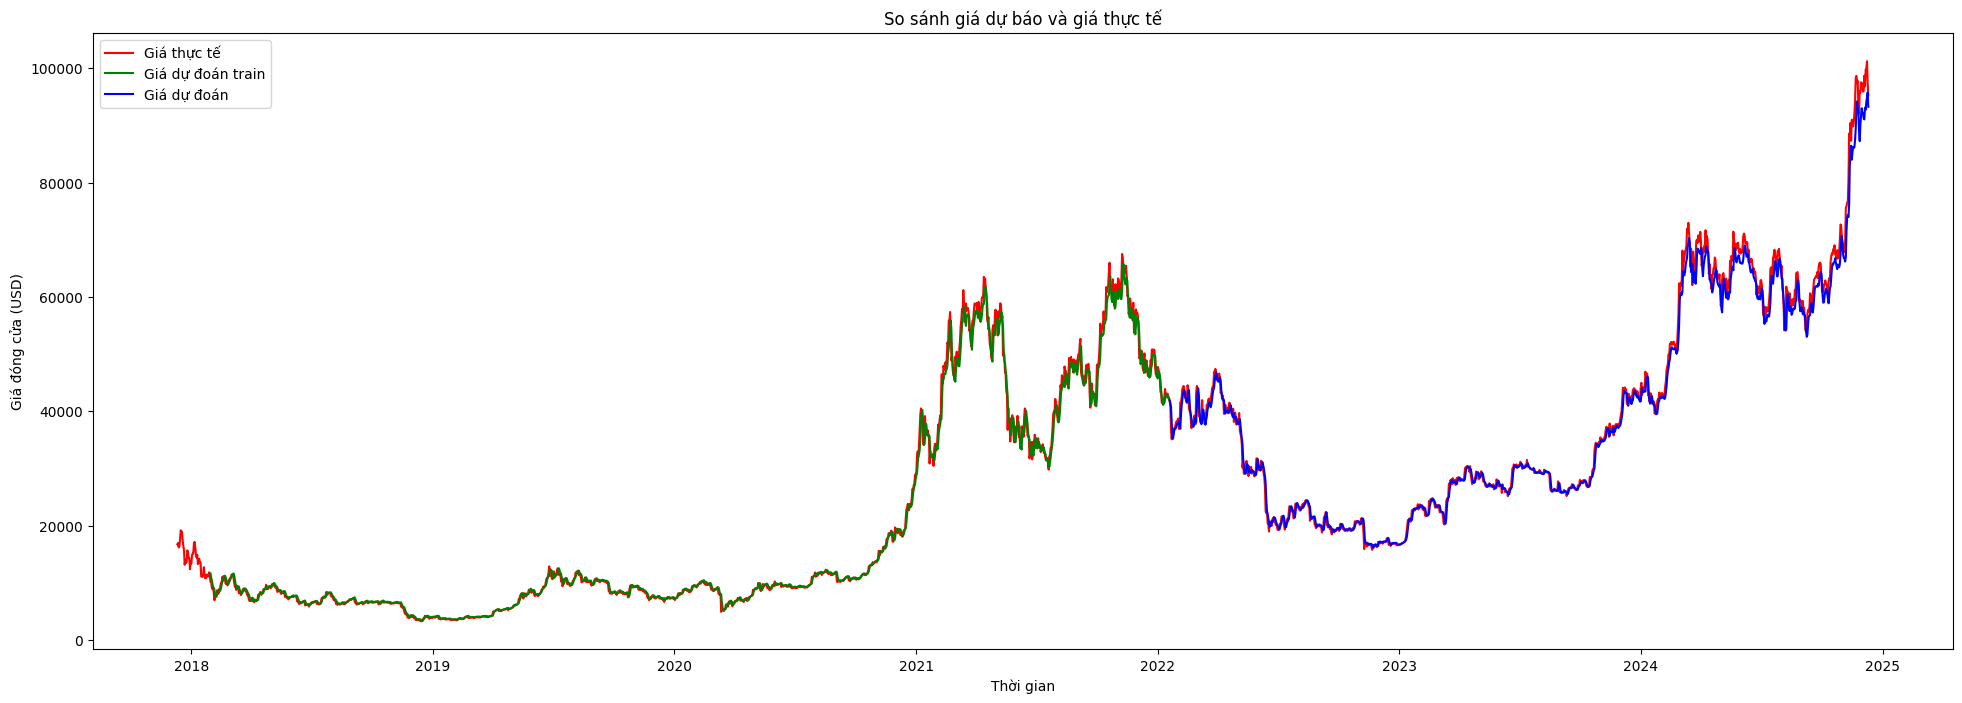

In [23]:
#lập biểu đồ so sánh
train_data1 = df1[50:1500]
test_data1 = df1[1500:]

plt.figure(figsize=(24,8))
plt.plot(df1,label='Giá thực tế',color='red') #đường giá thực
train_data1['Dự đoán'] = y_train_predict #thêm dữ liệu
plt.plot(train_data1['Dự đoán'], label='Giá dự đoán train',color='green') #đường giá dự báo train
#label='Giá dự đoán train'
test_data1['Dự đoán'] = y_test_predict #thêm dữ liệu
plt.plot(test_data1['Dự đoán'],label='Giá dự đoán',color='blue') #đường giá dự báo test
plt.title('So sánh giá dự báo và giá thực tế') #đặt tên biểu đồ
plt.xlabel('Thời gian') #đặt tên hàm x
plt.ylabel('Giá đóng cửa (USD)') #đặt tên hàm y
plt.legend() #chú thích
plt.show()

In [22]:
#r2
print('Độ phù hợp tập train:',r2_score(y_train,y_train_predict))
#mae
print('Sai số tuyệt đối trung bình trên tập train (VNĐ):',mean_absolute_error(y_train,y_train_predict))
#mae
print('Phần trăm sai số tuyệt đối trung bình tập train:',mean_absolute_percentage_error(y_train,y_train_predict))

Độ phù hợp tập train: 0.9897639731333777
Sai số tuyệt đối trung bình trên tập train (VNĐ): 1044.782841561153
Phần trăm sai số tuyệt đối trung bình tập train: 0.0527616297208842


In [23]:
train_data1

,Đóng cửa,Dự đoán
Ngày,,
2018-01-30,10175.0,11533.224609
2018-01-31,10284.0,10846.141602
2018-02-01,9181.1,10453.870117
2018-02-02,8895.8,9808.241211
2018-02-03,9219.4,9302.030273
...,...,...
2022-01-14,43091.0,40830.925781
2022-01-15,43069.0,40735.195312
2022-01-16,43084.0,40759.667969


In [24]:
#r2
print('Độ phù hợp tập test:',r2_score(y_test,y_test_predict))
#mae
print('Sai số tuyệt đối trung bình trên tập test (VNĐ):',mean_absolute_error(y_test,y_test_predict))
#mae
print('Phần trăm sai số tuyệt đối trung bình tập test:',mean_absolute_percentage_error(y_test,y_test_predict))

Độ phù hợp tập test: 0.9711592753776292
Sai số tuyệt đối trung bình trên tập test (VNĐ): 2353.460360986282
Phần trăm sai số tuyệt đối trung bình tập test: 0.04972610400912216


In [25]:
test_data1

,Đóng cửa,Dự đoán
Ngày,,
2022-01-19,41676.0,40177.195312
2022-01-20,40740.0,39763.132812
2022-01-21,36501.0,39032.316406
2022-01-22,35103.0,36278.906250
2022-01-23,36308.0,34138.324219
...,...,...
2024-12-06,99786.0,87928.585938
2024-12-07,99936.0,89567.031250
2024-12-08,101240.0,90168.453125


# Thử dự đoán giá tương lai và so sánh với giá ngày cuối

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


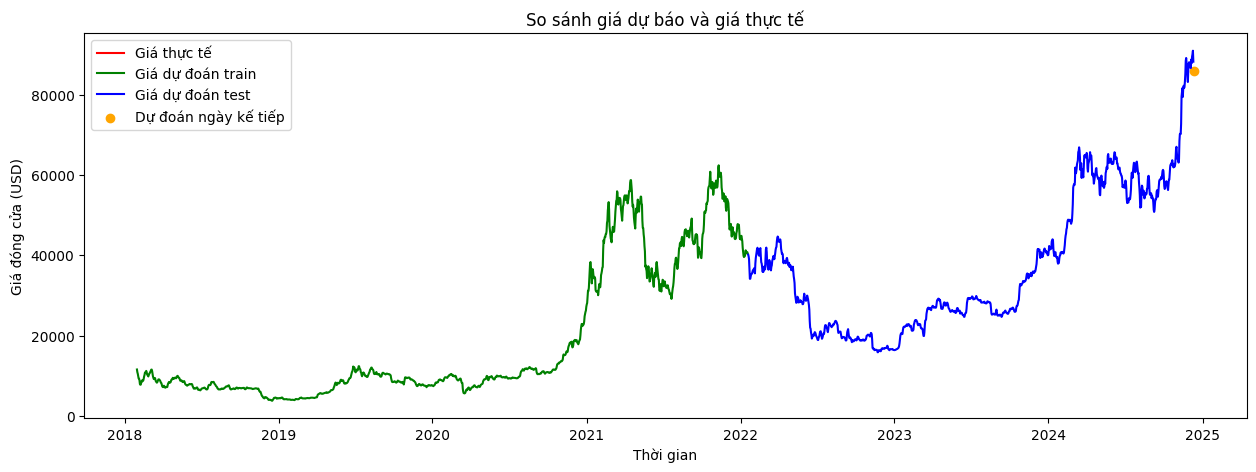

In [29]:
# Lấy ngày kế tiếp sau ngày cuối cùng trong tập dữ liệu để dự đoán
next_date = df['Ngày'].iloc[-1] + pd.Timedelta(days=1)

# Chuyển đổi ngày kế tiếp sang dạng datetime
next_date = pd.to_datetime(next_date)

# Lấy giá trị của ngày cuối cùng trong tập dữ liệu
next_closing_price = np.array([df['Đóng cửa'].iloc[-1]])  # Lấy giá trị đóng cửa của ngày cuối cùng

# Chuẩn hóa giá trị của ngày cuối cùng
next_closing_price_normalized = sc.transform(next_closing_price.reshape(-1, 1))  # Chuyển thành mảng 2D

# Tạo dự đoán cho ngày kế tiếp bằng mô hình đã huấn luyện
x_next = np.array([sc_train[-50:, 0]])  # Lấy 50 giá đóng cửa gần nhất
x_next = np.reshape(x_next, (x_next.shape[0], x_next.shape[1], 1))
y_next_predict = final_model.predict(x_next)
y_next_predict = sc.inverse_transform(y_next_predict)

# Thêm dữ liệu dự đoán của ngày kế tiếp vào DataFrame
df_next = pd.DataFrame({'Ngày': [next_date], 'Đóng cửa': [y_next_predict[0][0]]})
df1 = pd.concat([df1, df_next])

# Vẽ biểu đồ mới với dự đoán cho ngày kế tiếp
plt.figure(figsize=(15, 5))
plt.plot(df1['Ngày'], df1['Đóng cửa'], label='Giá thực tế', color='red')
plt.plot(train_data1.index, train_data1['Dự đoán'], label='Giá dự đoán train', color='green')
plt.plot(test_data1.index, test_data1['Dự đoán'], label='Giá dự đoán test', color='blue')
plt.scatter([next_date], [y_next_predict[0][0]], color='orange', label='Dự đoán ngày kế tiếp')
plt.xlabel('Thời gian')
plt.ylabel('Giá đóng cửa (USD)')
plt.title('So sánh giá dự báo và giá thực tế')
plt.legend()
plt.show()


In [28]:
# Lấy giá trị của ngày cuối cùng trong tập dữ liệu
actual_closing_price = df['Đóng cửa'].iloc[-1]

# Tạo DataFrame so sánh giá dự đoán với giá ngày cuối trong tập dữ liệu
comparison_df = pd.DataFrame({'Ngày': [next_date], 'Giá dự đoán': [y_next_predict[0][0]], 'Giá ngày trước': [actual_closing_price]})

# In ra bảng so sánh
print(comparison_df)

        Ngày  Giá dự đoán  Giá ngày trước
0 2024-12-11  85946.90625         95270.0
